In [1]:
import pandas as pd
import numpy as np
#import math
import seaborn as sn
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import quantile_transform



In [2]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score, classification_report, confusion_matrix

In [3]:
offers_classed=pd.read_pickle("final_table_nf.pkl")

In [4]:
labels=offers_classed['successful_offer'].values
print(len(labels))

66501


In [5]:
features = offers_classed.filter(['reward', 'difficulty', 'duration','mobile', 'social', 'web', 'bogo', 'discount',
                 'informational', 'age', 'became_member_on', 'income', 'female', 'male', 'other','total_spend','transaction','viewed'])
print(len(features))

66501


In [6]:
def quantileScale (df,col):
    col=df.filter(col)
    col_scaled=quantile_transform(col, copy=False)
    col=pd.DataFrame(col_scaled, columns=col.columns, index=col.index)
    df.update(col)
    return (df)

In [7]:
features.columns

Index(['reward', 'difficulty', 'duration', 'mobile', 'social', 'web', 'bogo',
       'discount', 'informational', 'age', 'became_member_on', 'income',
       'female', 'male', 'other', 'total_spend', 'transaction', 'viewed'],
      dtype='object')

In [8]:
features=quantileScale(features,['reward', 'difficulty', 'duration', 'mobile', 'social', 'web', 'bogo',
       'discount', 'informational', 'age', 'became_member_on', 'income',
       'female', 'male', 'other'])

features=features.values


In [9]:
#Convert features and labels to tensors
features = torch.as_tensor(features, dtype=torch.float)
labels = torch.as_tensor(labels, dtype=torch.long)

In [30]:
## Split data into three random datasets 

# Generate randomic indices
len_dataset = len(features)
random_idx = np.random.choice(len_dataset, len_dataset, replace=False)

# Use the proportions: train: 70%, valid: 15%, test: 15%
train_idx = random_idx[:int(len_dataset*0.70)]
valid_idx = random_idx[-int(len_dataset*0.15):]
test_idx = random_idx[int(len_dataset*0.70):-int(len_dataset*0.15)]

# Create datasets
train_dataset = TensorDataset(features[train_idx], labels[train_idx])
valid_dataset = TensorDataset(features[valid_idx], labels[valid_idx])
test_dataset = TensorDataset(features[test_idx], labels[test_idx])

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [31]:
#temp=[]

#for features, labels in test_dataloader:
#    print(features)
#    llist.append(features)

Making sure the split has maintained balanced classes

In [32]:
#Counting the training labels
train_neg = (labels[train_idx] == 0).sum()
train_pos = (labels[train_idx] == 1).sum()
train_total=len(train_idx)
print('Training data has {} unsuccessful events and {} successful events \nThe ratio between classes is:\t {:0.2f} : {:0.2f}\n'.format(train_neg, train_pos, train_neg/train_total, train_pos/train_total))

#Counting the validating labels
valid_neg = (labels[valid_idx] == 0).sum()
valid_pos = (labels[valid_idx] == 1).sum()
valid_total =len(valid_idx)
print('Training data has {} unsuccessful events and {} successful events \nThe ratio between classes is:\t {:0.2f} : {:0.2f}\n'.format(valid_neg, valid_pos, valid_neg/valid_total, valid_pos/valid_total))

#Counting the testing labels
test_neg = (labels[test_idx] == 0).sum()
test_pos = (labels[test_idx] == 1).sum()
test_total =len(test_idx)
print('Training data has {} unsuccessful events and {} successful events \nThe ratio between classes is:\t {:0.2f} : {:0.2f}\n'.format(test_neg, test_pos, test_neg/test_total, test_pos/test_total))


Training data has 26644 unsuccessful events and 19906 successful events 
The ratio between classes is:	 0.57 : 0.43

Training data has 5677 unsuccessful events and 4298 successful events 
The ratio between classes is:	 0.57 : 0.43

Training data has 5742 unsuccessful events and 4234 successful events 
The ratio between classes is:	 0.58 : 0.42



In [33]:
#import torch
import torch.nn as nn


class LinearNN(nn.Module):
    def __init__(self, input_size, hidden_layers=[128,128],
                 output_size=2, dropout=0.2):
        super(LinearNN, self).__init__()
        self.input_size = input_size

        nodes = []
        nodes.append(input_size)
        nodes.extend(hidden_layers)
        nodes.append(output_size)

        self.module_list = nn.ModuleList()
        for nodes_in, nodes_out in zip(nodes[:-1], nodes[1:]):
            layer = nn.Linear(nodes_in, nodes_out)
            self.module_list.append(layer)

        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x.view(-1, self.input_size)
        for layer in self.module_list[:-1]:
            x = layer(x)
            x = self.activation(x)
            x = self.dropout(x)
        x = self.module_list[-1](x)

        return x

In [34]:
def validate(model, dataloader=valid_dataloader):
    with torch.no_grad():
        model.eval()
        valid_loss = 0
        y_true = []
        y_pred = []
        for features, labels in dataloader:
            prediction = model(features)
            
            prediction = prediction.view(-1,2)
            labels = labels.view(-1)
            valid_loss += criterion(prediction, labels)

            prediction = torch.softmax(prediction, dim=1)
            _, prediction = prediction.topk(1, dim=1)
            prediction = prediction.squeeze()

            y_pred.extend(prediction.view(-1))
            y_true.extend(labels.view(-1))

        # normalize the loss
        valid_loss /= len(dataloader)
        valid_loss = valid_loss.item()

        # Calculate the metrics

#        recall = recall_score(y_true, y_pred, pos_label=1, average='binary')
#        recall0 = recall_score(y_true, y_pred, pos_label=0, average='binary')

#        fpr, tpr, thresholds_keras = roc_curve(y_true, y_pred)
#        auc_ = auc(fpr, tpr)

        con_mat = confusion_matrix(y_true, y_pred)
        class_report=classification_report(y_true, y_pred, digits=4, target_names=['unsuccessful','successful'],output_dict=False)
        roc_auc=roc_auc_score(y_true, y_pred)
        
        

        model.train()

        return valid_loss, con_mat, class_report, roc_auc
    
  
  #  print("auc_keras:" + str(auc_))

In [35]:
def train(model, model_name='classifier',
          dataloader=train_dataloader, epochs=5000):
    train_loss = []
    valid_loss = []
    min_valid_loss = np.inf
    ## Perform N epochs of training
    for epoch in range(1, epochs+1):
        epoch_loss = 0
        for batch, (features, labels) in enumerate(dataloader):
            ## Train the network
            optimizer.zero_grad()
            prediction = model(features)
            prediction = prediction.view(-1,2)
            labels = labels.view(-1)
            loss = criterion(prediction, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # Normalize the training loss
        epoch_loss /= len(dataloader)
        train_loss.append(epoch_loss)
        
        # LR scheduler step
        lr_scheduler.step(train_loss[-1])

        # Validate
        metrics = validate(model)
        valid_loss.append(metrics[0])
        print('Epoch {:4d}\ttrain loss: {:7.4f}\tvalidation loss: {:7.4f}' \
              .format(epoch, train_loss[-1], valid_loss[-1]))

        # Save the model if valid_loss has decreased
        if valid_loss[-1] < min_valid_loss:
            min_valid_loss = valid_loss[-1]
            torch.save(model.state_dict(), model_name+'.pt')

    return train_loss, valid_loss

In [36]:
linear_classifier = LinearNN(input_size=18, output_size=2, hidden_layers=[128,128,128])

criterion = nn.CrossEntropyLoss(torch.tensor([(float(train_neg) / float(train_pos)), 1])) #change this 2nd variable to change precision/recall threshold

optimizer = torch.optim.Adam(linear_classifier.parameters(), lr=0.0001, weight_decay=0.0001)

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=.2, patience=15, verbose=True)

In [38]:
%%time 
#200 takes 16min 35s

linear_loss = train(linear_classifier,
                    model_name='linear_classifier',
                    epochs=10)

Epoch    1	train loss:  0.6619	validation loss:  0.6144
Epoch    2	train loss:  0.6114	validation loss:  0.5988
Epoch    3	train loss:  0.5994	validation loss:  0.5929
Epoch    4	train loss:  0.5915	validation loss:  0.5893
Epoch    5	train loss:  0.5876	validation loss:  0.5808
Epoch    6	train loss:  0.5835	validation loss:  0.5798
Epoch    7	train loss:  0.5819	validation loss:  0.5750
Epoch    8	train loss:  0.5795	validation loss:  0.5765
Epoch    9	train loss:  0.5768	validation loss:  0.5743
Epoch   10	train loss:  0.5745	validation loss:  0.5707
CPU times: user 4min 54s, sys: 1.22 s, total: 4min 55s
Wall time: 2min 36s


In [39]:
#evaluate
loss, con_mat, class_report, roc_auc=  validate(linear_classifier, test_dataloader)

In [40]:
print(class_report)

              precision    recall  f1-score   support

unsuccessful     0.7038    0.7407    0.7218      5742
  successful     0.6214    0.5772    0.5985      4234

    accuracy                         0.6713      9976
   macro avg     0.6626    0.6590    0.6601      9976
weighted avg     0.6688    0.6713    0.6695      9976



In [ ]:
200 epochs of neural network

precision    recall  f1-score   support

unsuccessful     0.6988    0.8450    0.7650      5698
  successful     0.7138    0.5148    0.5982      4277

    accuracy                         0.7035      9975
   macro avg     0.7063    0.6799    0.6816      9975
weighted avg     0.7052    0.7035    0.6935      9975


In [ ]:
{'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 2, 'n_estimators': 100}

Classification report when hyper-params are optimised for :f1
              precision    recall  f1-score   support

unsuccessful     0.7212    0.7830    0.7508      5677
  successful     0.6769    0.6004    0.6363      4299

    accuracy                         0.7043      9976
   macro avg     0.6991    0.6917    0.6936      9976
weighted avg     0.7021    0.7043    0.7015      9976

<AxesSubplot:>

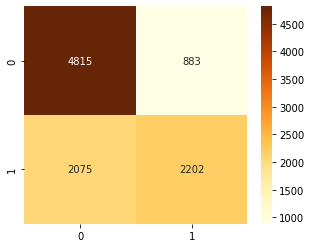

In [29]:
plt.figure(figsize = (5,4))
sn.heatmap(con_mat, annot=True,cmap='YlOrBr',fmt='g')

<AxesSubplot:>

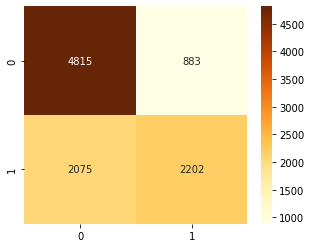

In [37]:
#200 epochs

plt.figure(figsize = (5,4))
sn.heatmap(con_mat, annot=True,cmap='YlOrBr',fmt='g')